# Data Cleaning & Feature Engineering

## Project Overview
This notebook executes the second phase of the machine learning pipeline: processing the raw ChEMBL data retrieved in the previous step.

**Key Objectives:**
1.  **Data Ingestion:** Load the aggregated inhibitor dataset.
2.  **Feature Engineering:** Decompose complex chemical strings (Molecular Formula) into numerical atomic features.
3.  **Data Densification:** Handle missing values in the generated features.
4.  **Export:** Prepare the final clean dataset for Exploratory Data Analysis (EDA) and Modeling.

## 1. Data Import
We begin by loading the raw dataset (`all_inhibitor_data_with_smiles.csv`) generated in the previous data retrieval module.

In [ ]:
import pandas as pd

file_path = '/content/all_inhibitor_data_with_smiles.csv'
df = pd.read_csv(file_path)

print(f"Dataset loaded from: {file_path}")
display(df.head())

Dataset loaded from: /content/all_inhibitor_data_with_smiles.csv


,ChEMBL ID,Preferred Name,logP,SMILES,aromatic_rings,full_molformula,full_mwt,hba,hbd,heavy_atoms,np_likeness_score,Target,Action
0,CHEMBL1085178,CHEMBL1085178,2.10,NaN,3.0,C18H22N6O2S,386.48,9.0,2.0,27.0,-1.15,PI3K alpha,inhibitor
1,CHEMBL1084926,CHEMBL1084926,1.79,NaN,3.0,C17H20N6O2S,372.45,9.0,2.0,26.0,-1.21,PI3K alpha,inhibitor
2,CHEMBL1256459,TORIN1,6.83,NaN,6.0,C35H28F3N5O2,607.64,6.0,0.0,45.0,-1.20,PI3K alpha,inhibitor
3,CHEMBL1684984,IZORLISIB,-0.33,NaN,2.0,C15H19N7O3S,377.43,9.0,1.0,26.0,-1.49,PI3K alpha,inhibitor
4,CHEMBL1765602,CHEMBL1765602,5.20,NaN,5.0,C24H15F3N4O,432.41,5.0,1.0,32.0,-0.85,PI3K alpha,inhibitor


In [ ]:
num_rows = df.shape[0]
print(f"The dataset contains {num_rows} rows.")

The dataset contains 78036 rows.


In [ ]:
missing_values_per_column = df.isnull().sum()
print("Sum of missing values per column:")
display(missing_values_per_column)

Sum of missing values per column:


,0
ChEMBL ID,0
Preferred Name,0
logP,226
SMILES,78036
aromatic_rings,226
full_molformula,113
full_mwt,113
hba,226
hbd,226
heavy_atoms,226


In [ ]:
if 'SMILES' in df.columns:
    df = df.drop(columns=['SMILES'])
    print("'SMILES' column removed successfully.")
else:
    print("'SMILES' column not found in the DataFrame.")

print("\nDataFrame head after removing 'SMILES' column:")
display(df.head())

'SMILES' column removed successfully.

DataFrame head after removing 'SMILES' column:


,ChEMBL ID,Preferred Name,logP,aromatic_rings,full_molformula,full_mwt,hba,hbd,heavy_atoms,np_likeness_score,Target,Action,missing_values_count
0,CHEMBL1085178,CHEMBL1085178,2.10,3.0,C18H22N6O2S,386.48,9.0,2.0,27.0,-1.15,PI3K alpha,inhibitor,1
1,CHEMBL1084926,CHEMBL1084926,1.79,3.0,C17H20N6O2S,372.45,9.0,2.0,26.0,-1.21,PI3K alpha,inhibitor,1
2,CHEMBL1256459,TORIN1,6.83,6.0,C35H28F3N5O2,607.64,6.0,0.0,45.0,-1.20,PI3K alpha,inhibitor,1
3,CHEMBL1684984,IZORLISIB,-0.33,2.0,C15H19N7O3S,377.43,9.0,1.0,26.0,-1.49,PI3K alpha,inhibitor,1
4,CHEMBL1765602,CHEMBL1765602,5.20,5.0,C24H15F3N4O,432.41,5.0,1.0,32.0,-0.85,PI3K alpha,inhibitor,1


In [ ]:
df = pd.get_dummies(df, columns=['Target'], prefix='Target')
print("DataFrame head after hot encoding 'Target' column:")
display(df.head())

DataFrame head after hot encoding 'Target' column:


,ChEMBL ID,Preferred Name,logP,aromatic_rings,full_molformula,full_mwt,hba,hbd,heavy_atoms,np_likeness_score,Action,missing_values_count,Target_AKT,Target_PI3K alpha,Target_PI3K beta,Target_PI3K delta,Target_PI3K gamma,Target_mTOR
0,CHEMBL1085178,CHEMBL1085178,2.10,3.0,C18H22N6O2S,386.48,9.0,2.0,27.0,-1.15,inhibitor,1,False,True,False,False,False,False
1,CHEMBL1084926,CHEMBL1084926,1.79,3.0,C17H20N6O2S,372.45,9.0,2.0,26.0,-1.21,inhibitor,1,False,True,False,False,False,False
2,CHEMBL1256459,TORIN1,6.83,6.0,C35H28F3N5O2,607.64,6.0,0.0,45.0,-1.20,inhibitor,1,False,True,False,False,False,False
3,CHEMBL1684984,IZORLISIB,-0.33,2.0,C15H19N7O3S,377.43,9.0,1.0,26.0,-1.49,inhibitor,1,False,True,False,False,False,False
4,CHEMBL1765602,CHEMBL1765602,5.20,5.0,C24H15F3N4O,432.41,5.0,1.0,32.0,-0.85,inhibitor,1,False,True,False,False,False,False


## 2. Feature Engineering: Elemental Composition

To utilize chemical composition as a predictive feature for our model, we must convert the string-based `full_molformula` (e.g., `C18H22N6O2S`) into structured numerical vectors.

We define a helper function, `parse_molformula`, which utilizes regular expressions to:
1.  **Tokenize** the string into individual atomic symbols (e.g., 'C', 'N', 'Cl').
2.  **Extract** the stoichiometric count for each element.
3.  **Normalize** the data by handling implicit counts (e.g., 'O' in a formula implies a count of 1).

In [7]:
import re

def parse_molformula(formula_string):
    """
    Parses a molecular formula string to extract element symbols and their counts.

    Args:
        formula_string (str): The molecular formula string (e.g., 'C6H12O6').

    Returns:
        dict: A dictionary where keys are element symbols and values are their counts.
              Returns an empty dictionary if the formula_string is NaN or invalid.
    """
    if pd.isna(formula_string):
        return {}

    element_counts = {}
    # Regex to find an element symbol (one uppercase letter OR one uppercase followed by one lowercase)
    # optionally followed by a number.
    # Example matches: C, H2, Cl, Br5
    pattern = r'([A-Z][a-z]?)([0-9]*)'
    matches = re.findall(pattern, formula_string)

    for element, count_str in matches:
        # If count_str is empty, it means the count is 1
        count = int(count_str) if count_str else 1
        element_counts[element] = element_counts.get(element, 0) + count

    return element_counts

print("The 'parse_molformula' function has been defined.")

# Test cases
# print(parse_molformula('C6H12O6'))
# print(parse_molformula('H2O'))
# print(parse_molformula('NaCl'))
# print(parse_molformula('CH3COOH'))
# print(parse_molformula('C'))
# print(parse_molformula(''))
# print(parse_molformula(float('nan')))

The 'parse_molformula' function has been defined.


## 3. Feature Extraction and Densification

We apply the parsing logic to the dataset to generate a sparse matrix of elemental counts.

**Process:**
1.  **Extraction:** The `parse_molformula` function is applied to every row, creating a new DataFrame where columns represent distinct elements (Carbon, Hydrogen, Oxygen, etc.).
2.  **Imputation:** Since molecules do not contain every element, the resulting data is sparse (containing `NaN`s). We impute these missing values with `0` to accurately reflect zero presence of that element.
3.  **Merging:** The new atomic features are concatenated with the original dataset, and the redundant `full_molformula` column is dropped.

In [8]:
element_counts_series = df['full_molformula'].apply(parse_molformula)
element_counts_df = pd.DataFrame.from_records(element_counts_series.tolist())

print("DataFrame head with extracted element counts:")
display(element_counts_df.head())

DataFrame head with extracted element counts:


,C,H,N,O,S,F,Cl,Br,I,P,B,Li,K,Si,Se
0,18.0,22.0,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17.0,20.0,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,35.0,28.0,5.0,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15.0,19.0,7.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24.0,15.0,4.0,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
element_counts_df = element_counts_df.fillna(0)

print("DataFrame head after filling NaN values with 0:")
display(element_counts_df.head())

DataFrame head after filling NaN values with 0:


,C,H,N,O,S,F,Cl,Br,I,P,B,Li,K,Si,Se
0,18.0,22.0,6.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,17.0,20.0,6.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,35.0,28.0,5.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15.0,19.0,7.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24.0,15.0,4.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df = pd.concat([df, element_counts_df], axis=1)
df = df.drop(columns=['full_molformula'])

print("DataFrame head after concatenating element counts and dropping 'full_molformula' column:")
display(df.head())
print("DataFrame info after update:")
df.info()

DataFrame head after concatenating element counts and dropping 'full_molformula' column:


,ChEMBL ID,Preferred Name,logP,aromatic_rings,full_mwt,hba,hbd,heavy_atoms,np_likeness_score,Action,...,F,Cl,Br,I,P,B,Li,K,Si,Se
0,CHEMBL1085178,CHEMBL1085178,2.10,3.0,386.48,9.0,2.0,27.0,-1.15,inhibitor,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CHEMBL1084926,CHEMBL1084926,1.79,3.0,372.45,9.0,2.0,26.0,-1.21,inhibitor,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CHEMBL1256459,TORIN1,6.83,6.0,607.64,6.0,0.0,45.0,-1.20,inhibitor,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CHEMBL1684984,IZORLISIB,-0.33,2.0,377.43,9.0,1.0,26.0,-1.49,inhibitor,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CHEMBL1765602,CHEMBL1765602,5.20,5.0,432.41,5.0,1.0,32.0,-0.85,inhibitor,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


DataFrame info after update:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78036 entries, 0 to 78035
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ChEMBL ID             78036 non-null  object 
 1   Preferred Name        78036 non-null  object 
 2   logP                  77810 non-null  float64
 3   aromatic_rings        77810 non-null  float64
 4   full_mwt              77923 non-null  float64
 5   hba                   77810 non-null  float64
 6   hbd                   77810 non-null  float64
 7   heavy_atoms           77810 non-null  float64
 8   np_likeness_score     77810 non-null  float64
 9   Action                78036 non-null  object 
 10  missing_values_count  78036 non-null  int64  
 11  Target_AKT            78036 non-null  bool   
 12  Target_PI3K alpha     78036 non-null  bool   
 13  Target_PI3K beta      78036 non-null  bool   
 14  Target_PI3K delta     78036 non-null  boo

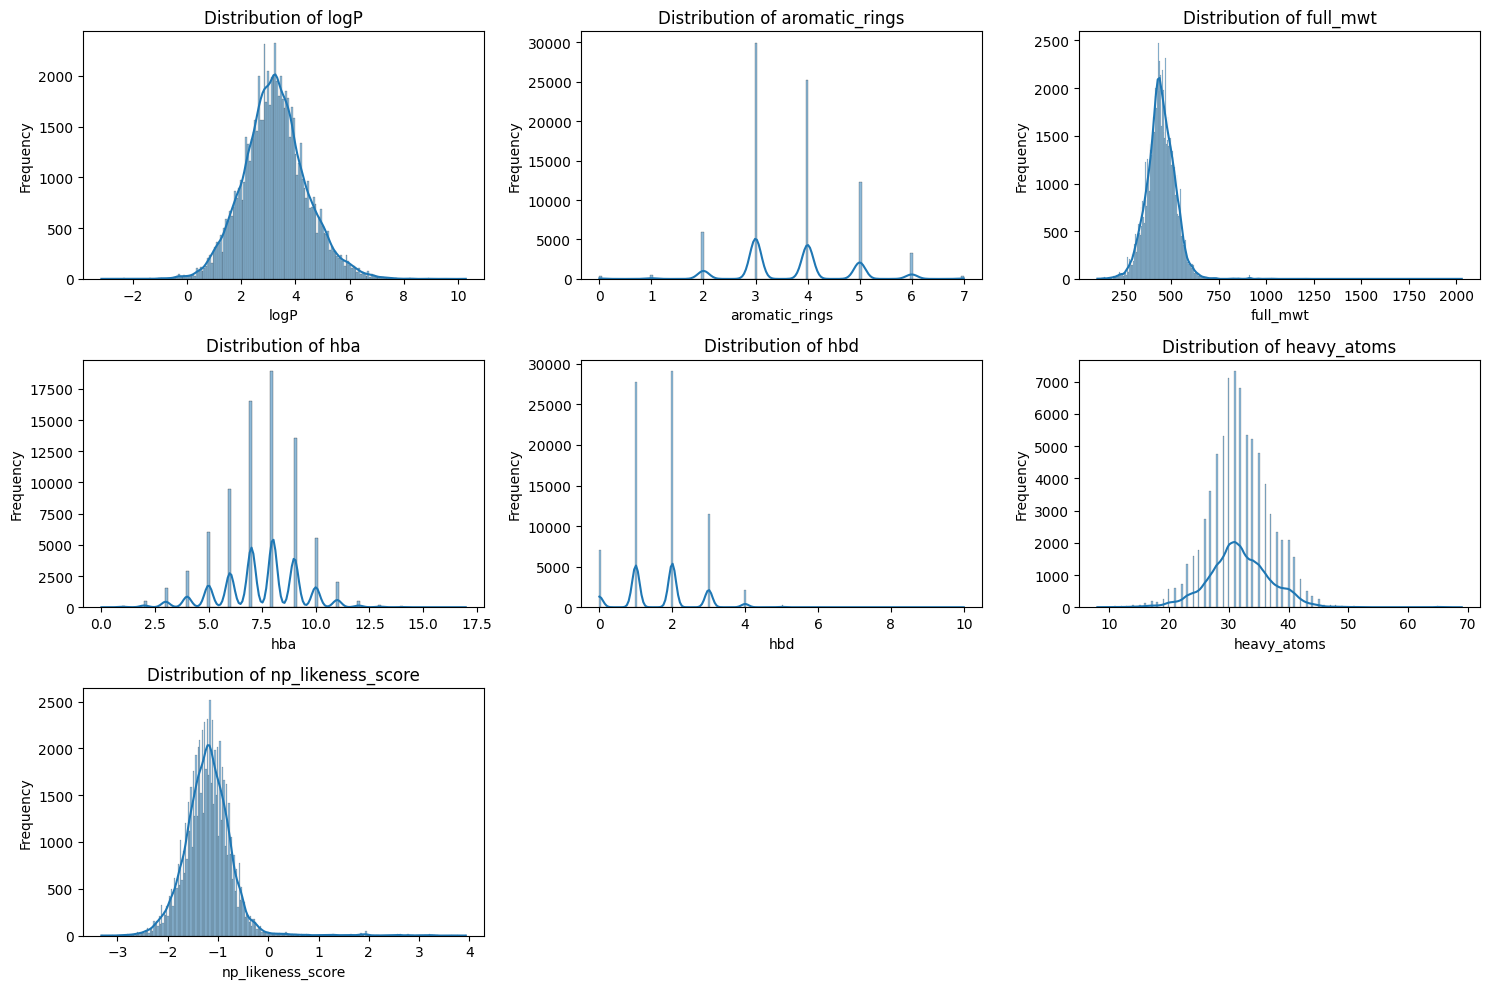

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns to create histograms for
columns_to_plot = [
    'logP',
    'aromatic_rings',
    'full_mwt',
    'hba',
    'hbd',
    'heavy_atoms',
    'np_likeness_score'
]

# Create a figure to hold all subplots
plt.figure(figsize=(15, 10))

# Loop through each column and create a histogram
for i, column in enumerate(columns_to_plot):
    plt.subplot(3, 3, i + 1) # Arrange plots in a 3x3 grid
    sns.histplot(df[column].dropna(), kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

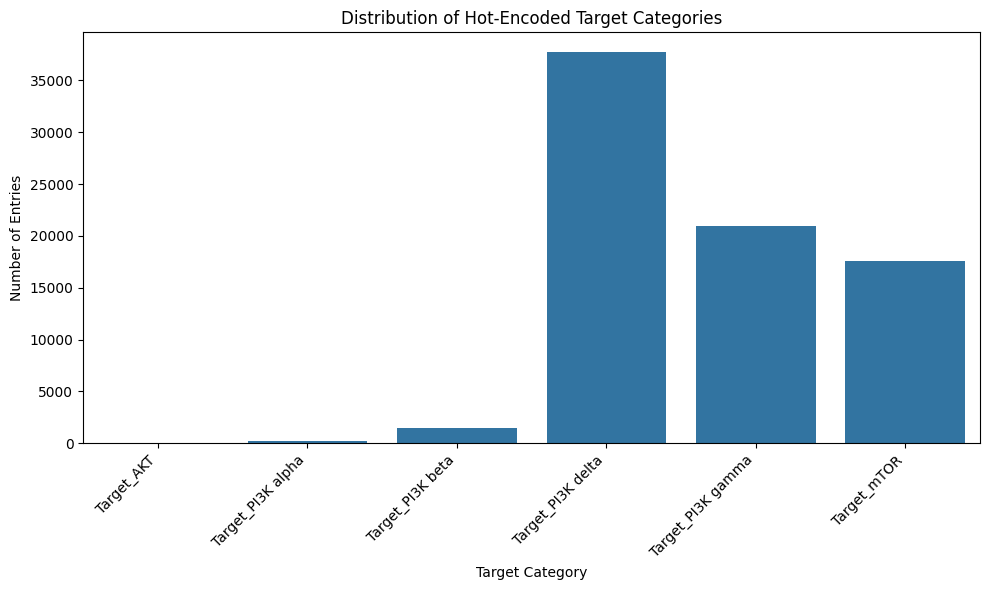

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify hot-encoded 'Target' columns
target_columns = [col for col in df.columns if col.startswith('Target_')]

# Calculate the sum of True values for each target column
target_counts = df[target_columns].sum()

# Convert to a DataFrame for easier plotting
target_counts_df = target_counts.reset_index()
target_counts_df.columns = ['Target', 'Count']

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Target', y='Count', data=target_counts_df)
plt.title('Distribution of Hot-Encoded Target Categories')
plt.xlabel('Target Category')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
print("Number of entries for each target:")
display(target_counts_df)

Number of entries for each target:


,Target,Count
0,Target_AKT,2
1,Target_PI3K alpha,232
2,Target_PI3K beta,1486
3,Target_PI3K delta,37753
4,Target_PI3K gamma,20989
5,Target_mTOR,17574


In [14]:
if 'Target_AKT' in df.columns:
    df = df.drop(columns=['Target_AKT'])
    print("'Target_AKT' column removed successfully.")
else:
    print("'Target_AKT' column not found in the DataFrame.")

print("\nDataFrame head after removing 'Target_AKT' column:")
display(df.head())

'Target_AKT' column removed successfully.

DataFrame head after removing 'Target_AKT' column:


,ChEMBL ID,Preferred Name,logP,aromatic_rings,full_mwt,hba,hbd,heavy_atoms,np_likeness_score,Action,...,F,Cl,Br,I,P,B,Li,K,Si,Se
0,CHEMBL1085178,CHEMBL1085178,2.10,3.0,386.48,9.0,2.0,27.0,-1.15,inhibitor,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CHEMBL1084926,CHEMBL1084926,1.79,3.0,372.45,9.0,2.0,26.0,-1.21,inhibitor,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CHEMBL1256459,TORIN1,6.83,6.0,607.64,6.0,0.0,45.0,-1.20,inhibitor,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CHEMBL1684984,IZORLISIB,-0.33,2.0,377.43,9.0,1.0,26.0,-1.49,inhibitor,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CHEMBL1765602,CHEMBL1765602,5.20,5.0,432.41,5.0,1.0,32.0,-0.85,inhibitor,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
if 'Action' in df.columns:
    df = df.drop(columns=['Action'])
    print("'Action' column removed successfully.")
else:
    print("'Action' column not found in the DataFrame.")

print("\nDataFrame head after removing 'Action' column:")
display(df.head())

'Action' column removed successfully.

DataFrame head after removing 'Action' column:


,ChEMBL ID,Preferred Name,logP,aromatic_rings,full_mwt,hba,hbd,heavy_atoms,np_likeness_score,missing_values_count,...,F,Cl,Br,I,P,B,Li,K,Si,Se
0,CHEMBL1085178,CHEMBL1085178,2.10,3.0,386.48,9.0,2.0,27.0,-1.15,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CHEMBL1084926,CHEMBL1084926,1.79,3.0,372.45,9.0,2.0,26.0,-1.21,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CHEMBL1256459,TORIN1,6.83,6.0,607.64,6.0,0.0,45.0,-1.20,1,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CHEMBL1684984,IZORLISIB,-0.33,2.0,377.43,9.0,1.0,26.0,-1.49,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CHEMBL1765602,CHEMBL1765602,5.20,5.0,432.41,5.0,1.0,32.0,-0.85,1,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4. Data Export
The cleaned and enriched dataset is saved as an Excel file (`processed_cleaned_data.xlsx`). This structured file preserves the new atomic features and is ready for the next stages: **Exploratory Data Analysis (EDA)** and **Model Training**.

In [16]:
output_file_path = 'processed_data.xlsx'
df.to_excel(output_file_path, index=False)
print(f"DataFrame successfully saved to {output_file_path}")

DataFrame successfully saved to processed_data.xlsx


In [17]:
print(f"DataFrame shape before dropping NaNs: {df.shape}")

columns_to_check = ['logP', 'aromatic_rings', 'full_mwt', 'hba', 'hbd', 'heavy_atoms', 'np_likeness_score']
df_cleaned = df.dropna(subset=columns_to_check)

print(f"DataFrame shape after dropping NaNs: {df_cleaned.shape}")
print("\nDataFrame head after removing rows with NaNs in specified columns:")
display(df_cleaned.head())

DataFrame shape before dropping NaNs: (78036, 30)
DataFrame shape after dropping NaNs: (77810, 30)

DataFrame head after removing rows with NaNs in specified columns:


,ChEMBL ID,Preferred Name,logP,aromatic_rings,full_mwt,hba,hbd,heavy_atoms,np_likeness_score,missing_values_count,...,F,Cl,Br,I,P,B,Li,K,Si,Se
0,CHEMBL1085178,CHEMBL1085178,2.10,3.0,386.48,9.0,2.0,27.0,-1.15,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CHEMBL1084926,CHEMBL1084926,1.79,3.0,372.45,9.0,2.0,26.0,-1.21,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CHEMBL1256459,TORIN1,6.83,6.0,607.64,6.0,0.0,45.0,-1.20,1,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CHEMBL1684984,IZORLISIB,-0.33,2.0,377.43,9.0,1.0,26.0,-1.49,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CHEMBL1765602,CHEMBL1765602,5.20,5.0,432.41,5.0,1.0,32.0,-0.85,1,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
output_file_path_cleaned = 'processed_cleaned_data.xlsx'
df_cleaned.to_excel(output_file_path_cleaned, index=False)
print(f"Cleaned DataFrame successfully saved to {output_file_path_cleaned}")